# UDD-MDS-IAA
UDD - Universidad del Desarrollo<br>
MDS - Master in Data Science<br><br>
**Project: Product Recommender**

This Notebook is to be used as part of the final evaluation on:
- Applyed Artificial Inteligence (IAA)

**Students**<br>
Rovai, Marcelo<br>
Sacasa, Manuel

**Professors**<br>
Reinoso, Pablo<br>
Seguel, Rodrigo
    
**May, 2019**

---
- Based on Yifan Hu et al, "Collaborative Filtering for Implicit Feedback Datasets"
- Using the library "Implicit", a Fast Python Collaborative Filtering for Implicit Datasets.
- https://github.com/benfred/implicit/
---

## General libraries import & initiation

In [253]:
import os
import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis

import urllib
import math
import seaborn as sns
import warnings

In [254]:
sns.set()
warnings.filterwarnings('ignore')
os.environ["MKL_NUM_THREADS"] = "1"

## Importing Dataset

In [255]:
!ls ../data

visual_1dia.csv  visual_meses.csv


In [256]:
df = pd.read_csv('../data/visual_meses.csv', sep=';')
df.shape

(187263, 33)

In [257]:
df.head()

,ID_GRUPO,PAIS,ID_CLIENTE,TX_NOMBRE,TX_ESTUDIO,COD_FECHA_VISUALIZACION,FECHA_PAIS,TX_DISP_CATEGORIA_ORIGINAL,TX_DISP_MODELO_ORIGINAL,TX_DISP_TIPO_ORIGINAL,...,NUMERO_TEMPORADA,NUMERO_CAPITULO,NOMBRE_CAPITULO,NOMBRE_CAPITULO_ESP,DURACION_TOTAL,ESTUDIO,PROVEEDOR,TYPE,PROGRAM_ID,TX_NOMBRE_SERIE
0,526402,CHILE,85528236.0,National Treasure,Disney,2018-10-01 10:04:34,2018-10-01 10:04:34,tv,lg,TV,...,NaN,NaN,NaN,NaN,02:10:59,Disney,AMCO,Type 2,13594853.0,NaN
1,526402,CHILE,211677990.0,National Treasure,Disney,2019-01-04 05:55:14,2019-01-04 05:55:14,web,html5,html5,...,NaN,NaN,NaN,NaN,02:10:59,Disney,AMCO,Type 2,13594853.0,NaN
2,526402,CHILE,186668874.0,National Treasure,Disney,2018-12-03 19:08:05,2018-12-03 19:08:05,tablet,android,SM-P350,...,NaN,NaN,NaN,NaN,02:10:59,Disney,AMCO,Type 2,13594853.0,NaN
3,526402,CHILE,30095082.0,National Treasure,Disney,2019-02-06 16:42:47,2019-02-06 16:42:47,mobile,android,XT1097,...,NaN,NaN,NaN,NaN,02:10:59,Disney,AMCO,Type 2,13594853.0,NaN
4,526402,CHILE,204313488.0,National Treasure,Disney,2018-10-06 17:43:37,2018-10-06 17:43:37,mobile,android,moto g(6) play,...,NaN,NaN,NaN,NaN,02:10:59,Disney,AMCO,Type 2,13594853.0,NaN


In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187263 entries, 0 to 187262
Data columns (total 33 columns):
ID_GRUPO                       187263 non-null int64
PAIS                           187263 non-null object
ID_CLIENTE                     182247 non-null float64
TX_NOMBRE                      187263 non-null object
TX_ESTUDIO                     187263 non-null object
COD_FECHA_VISUALIZACION        187263 non-null object
FECHA_PAIS                     187263 non-null object
TX_DISP_CATEGORIA_ORIGINAL     179370 non-null object
TX_DISP_MODELO_ORIGINAL        179370 non-null object
TX_DISP_TIPO_ORIGINAL          179370 non-null object
TX_DISP_VERSION_ORIGINAL       31521 non-null object
COD_PARTNER_OPERACION          174492 non-null float64
TIPO_OPERACION                 174332 non-null object
PRECIO                         187263 non-null int64
MEDIO_PAGO_NOMBRE              174332 non-null object
FECHA_ULT_VIS                  131148 non-null object
ULT_VIS                   

## Exploring Dataset

In [259]:
len(df.ID_CLIENTE.value_counts()) # 41,442 unique customers

41442

In [260]:
len(df.ID_GRUPO.value_counts()) # 12,845 unique id_grupo (titles on dataset)

12845

In [261]:
df.PAIS.value_counts() # only 1 country: Chile

CHILE    187263
Name: PAIS, dtype: int64

In [262]:
df.FECHA_PAIS.min()

'2018-09-01 00:01:24'

In [263]:
df.FECHA_PAIS.max()# 9 months of data

'2019-03-10 23:58:50'

In [264]:
df.TIPO_OPERACION.value_counts(
)  # There are 2 types of operation: Subscription (~94%) and Renta

Suscripcion    164019
Renta           10313
Name: TIPO_OPERACION, dtype: int64

In [265]:
df.MEDIO_PAGO_NOMBRE.value_counts()

Movil      135434
Fija        34923
Pincode      3740
Amco          235
Name: MEDIO_PAGO_NOMBRE, dtype: int64

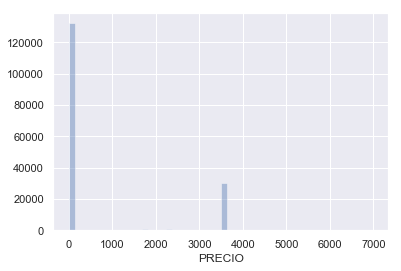

In [266]:
sns.distplot(
    df[df.TIPO_OPERACION == 'Suscripcion'].PRECIO, kde=False)
# Only ~20% of data with price

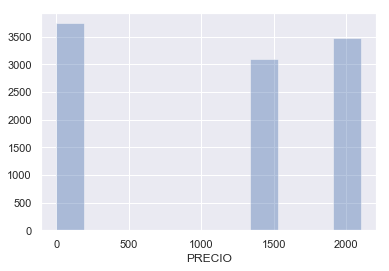

In [267]:
sns.distplot(
    df[df.TIPO_OPERACION == 'Renta'].PRECIO, kde=False)
# 2/3 of data with price

In [268]:
df[['TITULO', 'ID_GRUPO', 'TITULO_ESP',
    'CATEGORIA']].sample(10)  # TITULO is Majority in English or original

,TITULO,ID_GRUPO,TITULO_ESP,CATEGORIA
105192,Futurama,687993,Futurama - T10-Ep13,Serie
15373,"Emperors New Groove, The",540564,Las locuras del emperador,Pelicula
160612,Huaiquimán y Tolosa,774026,Huaiquimán y Tolosa - T01-Ep08,Serie
93780,Rudo y Cursi,653747,Rudo y Cursi,Pelicula
149669,New Girl,761743,New Girl - T06-Ep08,Serie
106480,"Bugs Life, A",692403,Bichos: Una aventura en miniatura,Pelicula
40124,Bend It Like Beckham,591806,Jugando con el destino,Pelicula
46206,"Walking Dead, The",593923,The Walking Dead - T01-Ep06,Serie
172442,"Beach, The (2000)",776435,La playa,Pelicula
80948,Malcolm in the Middle,613821,Malcolm el de en medio - T04-Ep01,Serie


In [269]:
df[df.ID_GRUPO == 613512]['TITULO_ESP'].sample(
    5)  # ID_GRUPO is unique for each item (even episody in series)

63441    Malcolm el de en medio - T01-Ep12
63412    Malcolm el de en medio - T01-Ep12
63460    Malcolm el de en medio - T01-Ep12
63267    Malcolm el de en medio - T01-Ep12
63278    Malcolm el de en medio - T01-Ep12
Name: TITULO_ESP, dtype: object

In [270]:
len(df.TX_NOMBRE.value_counts()) 

5017

In [271]:
len(df.TITULO.value_counts())  # 4,373 movie/series unique titles

4373

In [272]:
df.TITULO.value_counts()[:10] # Top 10 rents

Malcolm in the Middle             20789
Walking Dead, The                 10084
American Horror Story              6248
Bones                              5378
Modern Family                      4944
CSI: Crime Scene Investigation     3666
Outlander                          3652
Criminal Minds                     2893
Prison Break                       2795
Futurama                           2700
Name: TITULO, dtype: int64

In [273]:
df.CATEGORIA.value_counts()

Serie            123016
Pelicula          58845
Canal en Vivo      5402
Name: CATEGORIA, dtype: int64

In [274]:
len(df.TX_ESTUDIO.value_counts()) # 90 studios 

90

In [275]:
df.TX_ESTUDIO.value_counts()[:10] # Top 10 Studios

Fox                                       64636
Sony                                      25078
Disney                                    24071
FIC / Fox Latin American Channel, LLC     11354
Universal                                  9469
CBS                                        7192
Claro (Telmex) Chile                       7052
TELEFILMS - Whiland International S.A.     6050
AMCO                                       5402
Viz Media, LLC                             3943
Name: TX_ESTUDIO, dtype: int64

In [276]:
df.TX_DISP_CATEGORIA_ORIGINAL.value_counts()  # Device categories used

mobile     78102
tv         61533
web        28049
tablet      7229
console     2460
stb         1997
Name: TX_DISP_CATEGORIA_ORIGINAL, dtype: int64

In [277]:
len(df.TX_DISP_FABRICANTE_ORIGINAL.value_counts())  # 237 device brands

237

In [278]:
df.TX_DISP_FABRICANTE_ORIGINAL.value_counts()[:10]  # Top 10 device brands

samsung       50289
windows       27336
lg            23937
HUAWEI        19738
aapl          12132
motorola       8209
CHILE          7634
samsung,,,     4955
LGE            4055
sony           3029
Name: TX_DISP_FABRICANTE_ORIGINAL, dtype: int64

In [279]:
df.TX_DISP_MODELO_ORIGINAL.value_counts()  # Device models

android     70997
html5       27911
samsung     15823
aapl        13896
tizen       13496
webos       10678
lg           8051
web0s        7738
sony         3308
hisense      2387
w10          1658
ps4          1614
xbox_one      808
generic       690
slplayer      138
N9090          68
w8             38
ps3            22
ngv            19
xbox_360       16
sc7130         14
Name: TX_DISP_MODELO_ORIGINAL, dtype: int64

In [280]:
len(df.TX_DISP_TIPO_ORIGINAL.value_counts())  # 1,031 diff devices type

1031

In [281]:
df.TX_DISP_TIPO_ORIGINAL.value_counts()[:10]  # Top 10 devices type

TV                43589
html5             27911
tv                17821
iPhone            11428
SM-G610M           3745
ATU-LX3            2859
ANE-LX3            2724
generic            1911
moto g(6) play     1875
RNE-L03            1835
Name: TX_DISP_TIPO_ORIGINAL, dtype: int64

In [282]:
len(df.COD_PARTNER_OPERACION.value_counts())  # 71,312 diff partners

71312

In [283]:
print("There are {}% null data on MAX_VIS".format(
    round(100 * (df.MAX_VIS.isnull().sum() / len(df.MAX_VIS)))))

There are 30.0% null data on MAX_VIS


In [284]:
df[df.CATEGORIA == 'Pelicula'].MAX_VIS.describe(
)  # some cleaning is needed, minimum time is negative

count    4.168000e+04
mean    -1.893299e+01
std      1.882879e+04
min     -3.843942e+06
25%      3.200000e+01
50%      8.700000e+01
75%      1.050000e+02
max      2.210000e+02
Name: MAX_VIS, dtype: float64

In [285]:
df[df.CATEGORIA == 'Serie'].MAX_VIS.describe()

count    89187.000000
mean        33.482783
std         15.499141
min          0.000000
25%         22.000000
50%         41.000000
75%         44.000000
max        126.000000
Name: MAX_VIS, dtype: float64

In [286]:
df.ULT_VIS.describe()  # some cleaning is needed, minimum time is negative

count    1.311480e+05
mean     1.125590e+01
std      1.061458e+04
min     -3.843942e+06
25%      2.100000e+01
50%      4.000000e+01
75%      4.700000e+01
max      2.210000e+02
Name: ULT_VIS, dtype: float64

In [287]:
df.ULT_VIS[:10]

0      NaN
1      NaN
2      NaN
3    121.0
4      1.0
5    122.0
6    122.0
7    122.0
8     73.0
9    122.0
Name: ULT_VIS, dtype: float64

In [288]:
df.TYPE.value_counts()[:10]

Type 6           143577
Type EST 2         8180
Type 46D           6154
Type EST 1         5139
Type 66            5032
Type 67            4001
Type 2             2554
Type 3             2402
Type 63D           2340
Type 22 FINDE      2009
Name: TYPE, dtype: int64

---

### Exploratory data main finds
- All data is from Chile
- 6 months of data, collected from 09/01/2018 to 03/10/2029
- 187K observations:
    - "Serie"            123,016
    - "Pelicula"          58,845
    - "Canal en Vivo"      5,402
- 41,442 unique customers
- 12,845 different titles on dataset (id_grupo)
    - Each serie's episode has a unique id_grupo
- 4,373 unique movie/series titles
- There are 2 types of operation: Subscription (~94%) and Rent
- Majority of streaming happen in Mobile phones, followed by TV and Web Browsers
- 30% of "Max_vis", that is the maximum time spent on streaming is null

---

## Cleaning important data

In [289]:
df.TITULO.isnull().sum() 

0

In [290]:
df.ID_GRUPO.isnull().sum()

0

`TITULO and ID_GROUP are OK`

In [291]:
df.ID_CLIENTE.isnull().sum() 

5016

`Make no sense customers with Null ID, should be deleted`

In [292]:
i = len(df)
df = df[df.ID_CLIENTE.notnull()]
f = len(df)
print ("# lines deleted = ", f-i)

# lines deleted =  -5016


`ID_GRUPO and ID_CLIENTE will be converted to integer to reduce memory space`

In [293]:
df['ID_GRUPO'] = df.ID_GRUPO.astype(int)

In [294]:
df['ID_CLIENTE'] = df.ID_CLIENTE.astype(int)

In [295]:
df["DURACION_TOTAL"].isnull().sum()

3655

In [296]:
df[df["DURACION_TOTAL"].isnull()].CATEGORIA.value_counts()

Canal en Vivo    3653
Pelicula            2
Name: CATEGORIA, dtype: int64

`It is OK for Live TV has no data regarding total duration tme, but not a movie`

In [297]:
df[(df["DURACION_TOTAL"].isnull()) & (df.CATEGORIA == 'Pelicula')]

,ID_GRUPO,PAIS,ID_CLIENTE,TX_NOMBRE,TX_ESTUDIO,COD_FECHA_VISUALIZACION,FECHA_PAIS,TX_DISP_CATEGORIA_ORIGINAL,TX_DISP_MODELO_ORIGINAL,TX_DISP_TIPO_ORIGINAL,...,NUMERO_TEMPORADA,NUMERO_CAPITULO,NOMBRE_CAPITULO,NOMBRE_CAPITULO_ESP,DURACION_TOTAL,ESTUDIO,PROVEEDOR,TYPE,PROGRAM_ID,TX_NOMBRE_SERIE
183052,779381,CHILE,170628354,Born Racer,Universal,2019-01-29 09:59:08,2019-01-29 09:59:08,tv,samsung,TV,...,NaN,NaN,NaN,NaN,NaN,Universal,AMCO,Type EST 1,158923930.0,NaN
183053,779381,CHILE,213505602,Born Racer,Universal,2019-01-30 01:38:23,2019-01-30 01:38:23,mobile,android,SM-J610G,...,NaN,NaN,NaN,NaN,NaN,Universal,AMCO,Type EST 1,158923930.0,NaN


In [298]:
df[(df["DURACION_TOTAL"].isnull()) & (df.CATEGORIA == 'Pelicula')].MAX_VIS

183052    NaN
183053    0.0
Name: MAX_VIS, dtype: float64

`The content ID_GRUPO = 779381 has a null total duration time and was not seem by users (o or also null time). Those data should be deleted`

In [299]:
print(df.shape)
df = df[df.ID_GRUPO != 779381]
print(df.shape)

(182247, 33)
(182245, 33)


In [300]:
df["FECHA_PAIS"].describe()

count                  182245
unique                 180544
top       2019-03-04 17:49:55
freq                        3
Name: FECHA_PAIS, dtype: object

`Should be converted to datatime format`

In [301]:
df["FECHA_PAIS"] = pd.to_datetime(df["FECHA_PAIS"])

In [302]:
df.MAX_VIS.isnull().sum()

51098

In [303]:
df[df.MAX_VIS.isnull()].CATEGORIA.value_counts()

Serie            31569
Pelicula         16157
Canal en Vivo     3372
Name: CATEGORIA, dtype: int64

`MAX_VIS being Null make no sense for Series and movies (it is OK for Live TV), but could be kept because shows that spite that user could not "connect" (or data is wrong), he is in principle interested on that content. Let's converted Null to '1' (1 minute of view)`

In [304]:
df.MAX_VIS.fillna(1, inplace=True)

In [305]:
df.MAX_VIS.isnull().sum()

0

In [306]:
df[df.MAX_VIS <0]

,ID_GRUPO,PAIS,ID_CLIENTE,TX_NOMBRE,TX_ESTUDIO,COD_FECHA_VISUALIZACION,FECHA_PAIS,TX_DISP_CATEGORIA_ORIGINAL,TX_DISP_MODELO_ORIGINAL,TX_DISP_TIPO_ORIGINAL,...,NUMERO_TEMPORADA,NUMERO_CAPITULO,NOMBRE_CAPITULO,NOMBRE_CAPITULO_ESP,DURACION_TOTAL,ESTUDIO,PROVEEDOR,TYPE,PROGRAM_ID,TX_NOMBRE_SERIE
158720,773631,CHILE,159586500,Radio CorazÃ³n (2007),Claro (Telmex) Chile,2018-09-13 15:25:32,2018-09-13 15:25:32,web,html5,html5,...,NaN,NaN,NaN,NaN,01:46:58,Claro (Telmex) Chile,AMCO,Type 6,155656797.0,NaN


`Negative value should be eliminated`

In [307]:
df = df[df.MAX_VIS >0]

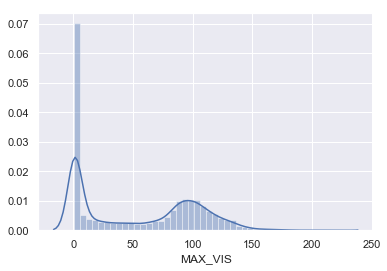

In [308]:
sns.distplot(df[df.CATEGORIA == 'Pelicula'].MAX_VIS)

In [309]:
df["DURACION_TOTAL"][500]

'01:53:14'

`The total duration time of content must be converted to minutes`

In [310]:
time = pd.DatetimeIndex(df['DURACION_TOTAL'])
time = time.hour*60 + time.minute +time.second/60.0
df['DURACION_TOTAL'] = time

In [311]:
df['DURACION_TOTAL'] = df['DURACION_TOTAL'].round(1)

In [312]:
df['DURACION_TOTAL'].sample(5)

45460      43.0
182087    112.3
38964      42.6
82120      22.5
54702      43.4
Name: DURACION_TOTAL, dtype: float64

In [313]:
df[df.CATEGORIA == 'Pelicula'].DURACION_TOTAL.describe()

count    56242.000000
mean       106.448453
std         21.433032
min          1.400000
25%         93.000000
50%        104.200000
75%        117.800000
max        220.700000
Name: DURACION_TOTAL, dtype: float64

In [314]:
df[df.CATEGORIA == 'Serie'].DURACION_TOTAL.describe()

count    119270.000000
mean         36.651149
std          13.996053
min           0.000000
25%          22.200000
50%          42.600000
75%          44.100000
max         238.200000
Name: DURACION_TOTAL, dtype: float64

In [315]:
df[df['DURACION_TOTAL']==0].CATEGORIA.value_counts()

Serie    26
Name: CATEGORIA, dtype: int64

`There are 26 items, Series episodes with total duration equal to zero. We must change it to median that should be 42 minutes`

In [316]:
df['DURACION_TOTAL'].replace ([0], [43], inplace=True)

In [317]:
df[df['DURACION_TOTAL']==0].CATEGORIA.value_counts()

Series([], Name: CATEGORIA, dtype: int64)

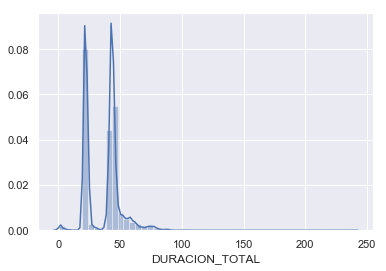

In [318]:
sns.distplot(df[df.CATEGORIA == 'Serie'].DURACION_TOTAL)

`There 2 concentrations on 30 and near 50 minutes for series, what make sense`

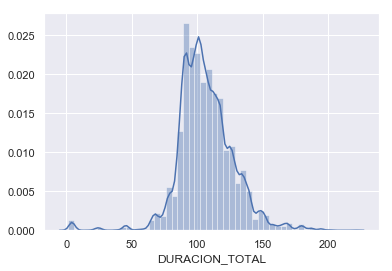

In [319]:
sns.distplot(df[df.CATEGORIA == 'Pelicula'].DURACION_TOTAL)

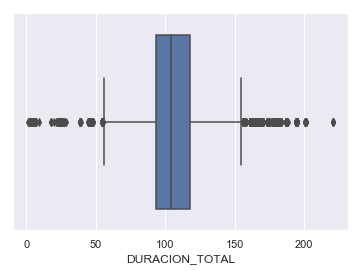

In [320]:
sns.boxplot(df[df.CATEGORIA == 'Pelicula'].DURACION_TOTAL)

`Movies total time goes around 2 hours, what's make sense. `

## User Overview

In [321]:
df.ID_CLIENTE.value_counts()[:10] # Several customers has multiple rents/attempts

85528236     774
188409510    295
164059254    207
181379730    171
157562346    170
185047890    143
182259888    143
185950170    141
204908244    131
182352906    116
Name: ID_CLIENTE, dtype: int64

In [322]:
df[(df.ID_CLIENTE == 85528236.) & (df.CATEGORIA == "Pelicula")].TITULO[:10]

0                                       National Treasure
37                                      National Treasure
172                                 Poohs Heffalump Movie
722       Cansada de besar sapos (Tired of Kissing Frogs)
765                                   Simpsons Movie, The
766                                   Simpsons Movie, The
1144             National Treasure 2: The Book of Secrets
1368    Chronicles of Narnia, The: The Lion, the Witch...
2360                               Hills Have Eyes 2, The
2361                               Hills Have Eyes 2, The
Name: TITULO, dtype: object

In [323]:
def get_user_watched_content(df, id_client, content='Pelicula', n=10):
    data = df[(df.ID_CLIENTE == id_client) & (df.CATEGORIA == content)]
    return data[[
        'FECHA_PAIS', 'ID_GRUPO', 'TITULO', 'DURACION_TOTAL', 'MAX_VIS',
        'TX_DISP_CATEGORIA_ORIGINAL'
    ]][:n]

In [324]:
get_user_watched_content(df, 85528236, content = 'Pelicula')

,FECHA_PAIS,ID_GRUPO,TITULO,DURACION_TOTAL,MAX_VIS,TX_DISP_CATEGORIA_ORIGINAL
0,2018-10-01 10:04:34,526402,National Treasure,131.0,1.0,tv
37,2018-09-26 20:35:22,526402,National Treasure,131.0,65.0,mobile
172,2018-10-24 02:35:55,526403,Poohs Heffalump Movie,68.3,64.0,web
722,2018-10-01 00:46:11,526478,Cansada de besar sapos (Tired of Kissing Frogs),95.9,92.0,web
765,2018-12-22 07:45:22,526487,"Simpsons Movie, The",86.8,1.0,stb
766,2018-12-22 07:27:43,526487,"Simpsons Movie, The",86.8,1.0,stb
1144,2019-01-03 06:26:21,526515,National Treasure 2: The Book of Secrets,124.4,1.0,stb
1368,2019-01-04 04:11:57,526602,"Chronicles of Narnia, The: The Lion, the Witch...",140.2,1.0,stb
2360,2018-10-03 02:17:21,527901,"Hills Have Eyes 2, The",90.3,86.0,stb
2361,2018-10-03 01:47:10,527901,"Hills Have Eyes 2, The",90.3,86.0,stb


In [325]:
get_user_watched_content(df, 85528236, content = 'Serie')

,FECHA_PAIS,ID_GRUPO,TITULO,DURACION_TOTAL,MAX_VIS,TX_DISP_CATEGORIA_ORIGINAL
21346,2018-09-24 22:57:35,552506,"Nanny, The",23.7,23.0,tv
21982,2018-12-06 01:05:54,553140,"Nanny, The",23.6,1.0,stb
23013,2018-10-09 15:38:09,555540,Creature Comforts,21.8,13.0,stb
27416,2018-10-01 11:16:17,569962,Castle: Nikki Heat,42.1,42.0,web
28352,2018-11-09 22:44:14,572244,Niñas mal 1,40.7,40.0,tv
28540,2018-12-14 04:31:20,573522,Niñas mal 1,40.2,1.0,tv
28542,2018-12-08 13:10:42,573525,Niñas mal 1,40.4,1.0,tv
30964,2018-10-11 19:37:35,577360,Drake & Josh,23.5,24.0,tv
31050,2018-09-29 15:29:02,577369,Drake & Josh,24.4,24.0,tv
31934,2018-10-29 16:59:39,579230,"Go, Diego, Go!: All Aboard, The Giant Panda Ex...",23.0,23.0,tv


---

## Dataset Enhancement

`A new column is created with the simple (and clean) title, been series (w/0 "s2e7" for example) or movie`

In [326]:
def label_rec(row):
    return row["TX_NOMBRE_SERIE"] if row["CATEGORIA"] == "Serie" else row[
        "TITULO"]

In [327]:
df["LABEL_REC"] = df.apply(label_rec, axis=1)

`A new column with percentage of max view is created`

In [334]:
def label_dur(row):
    return round((row["MAX_VIS"] / row["DURACION_TOTAL"]), 2)

In [335]:
df["LABEL_DUR"] = df.apply(label_dur, axis=1)

In [336]:
df["LABEL_DUR"].describe()

count    175512.000000
mean          0.634801
std           0.442192
min           0.000000
25%           0.050000
50%           0.960000
75%           1.000000
max           1.960000
Name: LABEL_DUR, dtype: float64

In [786]:
df[df["LABEL_DUR"]==0]

,ID_GRUPO,PAIS,ID_CLIENTE,TX_NOMBRE,TX_ESTUDIO,COD_FECHA_VISUALIZACION,FECHA_PAIS,TX_DISP_CATEGORIA_ORIGINAL,TX_DISP_MODELO_ORIGINAL,TX_DISP_TIPO_ORIGINAL,...,NOMBRE_CAPITULO,NOMBRE_CAPITULO_ESP,DURACION_TOTAL,ESTUDIO,PROVEEDOR,TYPE,PROGRAM_ID,TX_NOMBRE_SERIE,LABEL_REC,LABEL_DUR
101916,680593,CHILE,213577488,"Lord of the Rings, The: The Return of the King",Warner Bros. Home Entertainment Inc.,2019-01-12 15:35:46,2019-01-12 15:35:46,tv,samsung,tv,...,NaN,NaN,200.9,Warner Bros. Home Entertainment Inc.,AMCO,Type 22 FINDE,26298947.0,NaN,"Lord of the Rings, The: The Return of the King",0.0
101919,680593,CHILE,211666500,"Lord of the Rings, The: The Return of the King",Warner Bros. Home Entertainment Inc.,2018-12-26 14:32:24,2018-12-26 14:32:24,tablet,android,SM-T560,...,NaN,NaN,200.9,Warner Bros. Home Entertainment Inc.,AMCO,Type 22 FINDE,26298947.0,NaN,"Lord of the Rings, The: The Return of the King",0.0
101922,680593,CHILE,213577488,"Lord of the Rings, The: The Return of the King",Warner Bros. Home Entertainment Inc.,2019-01-11 18:17:00,2019-01-11 18:17:00,tv,samsung,tv,...,NaN,NaN,200.9,Warner Bros. Home Entertainment Inc.,AMCO,Type 22 FINDE,26298947.0,NaN,"Lord of the Rings, The: The Return of the King",0.0
139535,755385,CHILE,166518276,Gone with the Wind,Warner Bros. Home Entertainment Inc.,2019-01-20 03:36:40,2019-01-20 03:36:40,tv,samsung,tv,...,NaN,NaN,220.7,Warner Bros. Home Entertainment Inc.,AMCO,Type 2,30452792.0,NaN,Gone with the Wind,0.0
139538,755385,CHILE,209831094,Gone with the Wind,Warner Bros. Home Entertainment Inc.,2019-02-24 12:30:26,2019-02-24 12:30:26,mobile,aapl,iPhone,...,NaN,NaN,220.7,Warner Bros. Home Entertainment Inc.,AMCO,Type 2,30452792.0,NaN,Gone with the Wind,0.0
139539,755385,CHILE,209831094,Gone with the Wind,Warner Bros. Home Entertainment Inc.,2019-02-24 12:29:26,2019-02-24 12:29:26,mobile,aapl,iPhone,...,NaN,NaN,220.7,Warner Bros. Home Entertainment Inc.,AMCO,Type 2,30452792.0,NaN,Gone with the Wind,0.0
170623,775841,CHILE,209022054,Buenos Aires 2018: Atletismo,"Claro Video, Inc (F/n/a DLA, Inc.)",2018-11-19 11:08:05,2018-11-19 11:08:05,web,html5,html5,...,Final Femenil y Varonil día 1,Final Femenil y Varonil día 1,238.2,"Claro Video, Inc (F/n/a DLA, Inc.)",AMCO,Type 9,500748.0,Buenos Aires 2018: Atletismo,Buenos Aires 2018: Atletismo,0.0


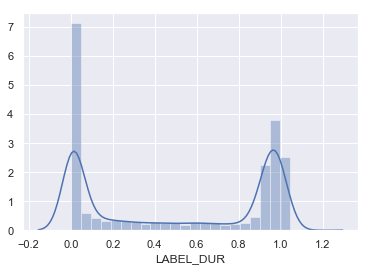

In [337]:
sns.distplot(df[df.CATEGORIA == 'Pelicula'].LABEL_DUR);

`Create single tables, one for each Categories ("Serie","Pelicula" and "Canal en Vivo"), but where users have seen more than 60% of individual content (LABEL_DUR).`  

In [338]:
df.CATEGORIA.value_counts()

Serie            119270
Pelicula          56242
Canal en Vivo      3372
Name: CATEGORIA, dtype: int64

In [339]:
df_movies = df[(df.CATEGORIA == 'Pelicula') & (df.LABEL_DUR > 0.60)]
df_series = df[(df.CATEGORIA == 'Serie') & (df.LABEL_DUR > 0.60)]
df_canal = df[df.CATEGORIA == 'Canal en Vivo']

In [340]:
len(df_movies)

27246

In [341]:
print(len(df_movies))
df_movies = df_movies.drop_duplicates(subset=['ID_GRUPO'])
print(len(df_movies))

27246
1856


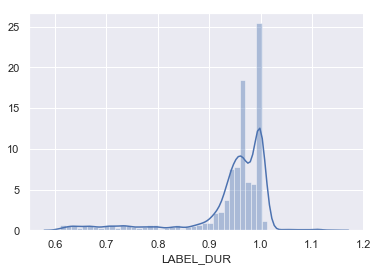

In [343]:
sns.distplot(df_movies.LABEL_DUR);

In [342]:
print(len(df_series))
df_series = df_series.drop_duplicates(subset=['ID_GRUPO'])
print(len(df_series))

81316
9196


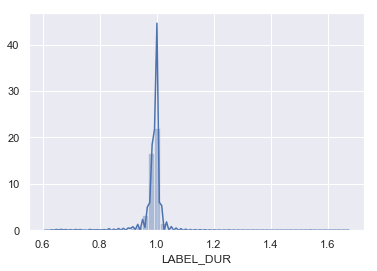

In [344]:
sns.distplot(df_series.LABEL_DUR);

---
## Marketing Approach

`Once we have 2 prepared datasets, one for movies and one for series, where only content that was really seen was kept, is interesting to answer some marketing questions as what were the most saw movies and series on current/past month? Those answers will be important to recommend content to users that has not enough data to be used with trained model.`

In [579]:
mov_id = list(df_movies[df_movies.FECHA_PAIS > '2019-02-01'].ID_GRUPO.
              value_counts()[:10].index)
mov_id

[680953,
 536902,
 778548,
 605493,
 711992,
 757049,
 716084,
 542014,
 531775,
 756410]

In [607]:
mo_recs_mov = df_movies[df_movies['ID_GRUPO'].isin(mov_id)]
mo_recs_mov = mo_recs_mov[['ID_GRUPO', 'TITULO']]
mo_recs_mov

,ID_GRUPO,TITULO
8885,531775,League of Extraordinary Gentlemen. The
11511,536902,Mean Girls (2004)
16222,542014,"Admiral, The (aka Isoroku Yamamoto)"
60343,605493,Megafactories: Extreme Roller Coaster
102055,680953,Recién casados
114028,711992,Curious George 3: Back to the Jungle
115142,716084,"Pequeños privilegios, Los"
141276,756410,Inframundo
144271,757049,Eragon (2006)
180662,778548,Karate Kid


In [608]:
ser_id = list(df_series[df_series.FECHA_PAIS > '2019-02-01'].ID_GRUPO.
              value_counts()[:10].index)
mo_recs_ser = df_series[df_series['ID_GRUPO'].isin(ser_id)]
mo_recs_ser = mo_recs_ser[['ID_GRUPO', 'TITULO']]
mo_recs_ser

,ID_GRUPO,TITULO
32236,580933,Ultimate Spider-Man
103261,685392,Saving Grace
107847,694736,Family Guy
125462,730798,Gran Hotel
135321,750951,"muñecas de la mafia, Las"
139374,755020,Esmeraldas
139377,755022,Esmeraldas
156697,771970,Hijos de su madre
175734,777539,Reign
178357,778192,Señora Acero


___

## Implicity Library Installation 

---
## Data Pre-processing for using with Implicit

In [355]:
def associate(df):
    users = {}
    products = {}

    for (code, cat) in enumerate(df.ID_GRUPO.cat.categories):
        products[code] = cat

    for (code, cat) in enumerate(df.ID_CLIENTE.cat.categories):
        users[cat] = code
        
    return users, products

In [345]:
df_movies_grouped = df_movies.groupby(['ID_CLIENTE','ID_GRUPO']).size().reset_index(name='counts')

In [346]:
df_series_grouped = df_series.groupby(['ID_CLIENTE','ID_GRUPO']).size().reset_index(name='counts')

In [347]:
df_canal_grouped = df_canal.groupby(['ID_CLIENTE','ID_GRUPO']).size().reset_index(name='counts')

In [348]:
df_movies_grouped.head()

,ID_CLIENTE,ID_GRUPO,counts
0,16674318,570551,1
1,18646398,529562,1
2,18646398,773143,1
3,20339730,764486,1
4,21230568,527916,1


In [349]:
df_movies_grouped.counts.describe()

count    1856.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: counts, dtype: float64

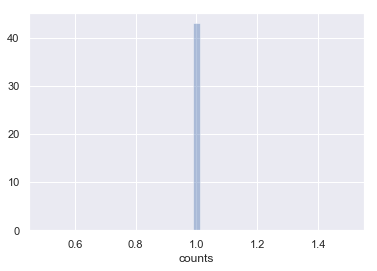

In [350]:
sns.distplot(df_movies_grouped.counts);

In [351]:
df_series_grouped.head()

,ID_CLIENTE,ID_GRUPO,counts
0,16617714,564521,1
1,16618290,771134,1
2,16618290,771163,1
3,16700118,556423,1
4,17475474,770730,1


In [352]:
df_series_grouped.counts.describe()

count    9196.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: counts, dtype: float64

In [353]:
df_movies_grouped['ID_CLIENTE'] = df_movies_grouped['ID_CLIENTE'].astype("category")
df_movies_grouped['ID_GRUPO'] = df_movies_grouped['ID_GRUPO'].astype("category")

m_amount_users = len(df_movies_grouped.ID_CLIENTE.cat.categories)
m_amount_content = len(df_movies_grouped.ID_GRUPO.cat.categories)

In [354]:
df_series_grouped['ID_CLIENTE'] = df_series_grouped['ID_CLIENTE'].astype("category")
df_series_grouped['ID_GRUPO'] = df_series_grouped['ID_GRUPO'].astype("category")

s_amount_users = len(df_series_grouped.ID_CLIENTE.cat.categories)
s_amount_content = len(df_series_grouped.ID_GRUPO.cat.categories)

In [356]:
movies_users, movies_content = associate(df_movies_grouped)
movies_content_inv = {v: k for k, v in movies_content.items()}

In [357]:
series_users, series_content = associate(df_series_grouped)
series_content_inv = {v: k for k, v in series_content.items()}

---

## Applying Implicit Library 

In [358]:
from sklearn.model_selection import train_test_split
from implicit.approximate_als import NMSLibAlternatingLeastSquares
from scipy.sparse import csr_matrix

In [359]:
def filter_min_interactions(df, n = 4):
    return df.groupby('ID_CLIENTE').filter(lambda x: len(x) > n)

`To real make sense, a recommender model based on content seen by a user must have a minimum of items saw by an individual customer in order to use it for recommendation. 4 is an empirical value`

### Applying Implicit Library to Movies

`Unfortunately, this dataset does not have users that have several real saw content, so we will keep n=1, instead of desired 4.`

In [360]:
df_movies_grouped = filter_min_interactions(df_movies_grouped, 1)

In [361]:
df_movies_train, df_movies_test = train_test_split(df_movies_grouped, test_size=.2, random_state=0)

In [362]:
df_movies_train_csr = csr_matrix((df_movies_train.counts,
                                  (df_movies_train.ID_GRUPO.cat.codes,
                                   df_movies_train.ID_CLIENTE.cat.codes)),
                                 shape=(m_amount_content, m_amount_users))
df_movies_csr = csr_matrix((df_movies_grouped.counts,
                            (df_movies_grouped.ID_GRUPO.cat.codes,
                             df_movies_grouped.ID_CLIENTE.cat.codes)),
                           shape=(m_amount_content, m_amount_users))
m_model = NMSLibAlternatingLeastSquares(
    factors=35,
    regularization=0.5,
    iterations=25,
    calculate_training_loss=True)

print("Starting Training movies model")
m_model.fit(df_movies_train_csr * 5.0)
print("Trained movies model")

 32%|███▏      | 8.0/25 [00:00<00:00, 49.39it/s, loss=0.00161]

Starting Training movies model


100%|██████████| 25.0/25 [00:00<00:00, 49.88it/s, loss=0.00161]


Trained movies model


### Applying Implicit Library to Series

`Unfortunately, this dataset does not have users that have several real saw content, so we will keep n=1, instead of desired 4.`

In [363]:
df_series_grouped = filter_min_interactions(df_series_grouped, 1)
df_series_train, df_series_test = train_test_split(df_series_grouped, test_size=.2, random_state=0)

In [364]:
df_series_train_csr = csr_matrix((df_series_train.counts,
                                  (df_series_train.ID_GRUPO.cat.codes,
                                   df_series_train.ID_CLIENTE.cat.codes)),
                                 shape=(s_amount_content, s_amount_users))
df_series_csr = csr_matrix((df_series_grouped.counts,
                            (df_series_grouped.ID_GRUPO.cat.codes,
                             df_series_grouped.ID_CLIENTE.cat.codes)),
                           shape=(s_amount_content, s_amount_users))
s_model = NMSLibAlternatingLeastSquares(
    factors=35,
    regularization=0.5,
    iterations=25,
    calculate_training_loss=True)

print("Starting Training Series model")
s_model.fit(df_series_train_csr * 5.0)
print("Trained Series model")

 16%|█▌        | 4.0/25 [00:00<00:00, 30.10it/s, loss=0.00397]

Starting Training Series model


100%|██████████| 25.0/25 [00:00<00:00, 29.88it/s, loss=0.00396]


Trained Series model


---

## Testing Model

In [441]:
def recommend_movies(df, id_client):
    watched = get_user_watched_content(df, id_client, "Pelicula")
    recs = get_user_recommendations(m_model, df_movies_csr, movies_users,
                                        movies_content, movies_content_inv,
                                        id_client, df_movies_grouped)

    return watched, recs

In [442]:
def recommend_series(df, id_client):
    watched = get_user_watched_content(df, id_client, "Serie")
    recs = get_user_recommendations(s_model, df_series_csr, series_users,
                                    series_content, series_content_inv,
                                    id_client, df_series_grouped)
    
    return watched, recs

In [451]:
def get_user_watched_content(df, id_client, content='Pelicula'):
    data = df[(df.ID_CLIENTE == id_client) & (df.CATEGORIA == content)]
    data = data.drop_duplicates(subset=['TITULO'])
    return data[['ID_CLIENTE', 'ID_GRUPO', 'TITULO', 'LABEL_REC', 'CATEGORIA']]

In [458]:
def get_user_recommendations(model, user_item_matrix, user_mapping,
                             content_mapping, content_mapping_inv, id_client,
                             df_data):
    _filter = [
        content_mapping_inv[idx] for idx in df_data[
            df_data['ID_CLIENTE'] == id_client].ID_GRUPO.unique()
    ]
    _recs = model.recommend(
        user_mapping[id_client], user_item_matrix.T, N=10, filter_items=_filter)
    _pre_df = [{
        'ID_CLIENTE': id_client,
        'ID_GRUPO': content_mapping[content_id],
        'confidence': score
    } for (content_id, score) in _recs]
    _df = pd.DataFrame(_pre_df)
    recs = pd.merge(_df, df[['ID_GRUPO', 'TITULO', 'LABEL_REC', 'CATEGORIA']], how='inner')
    recs = recs.drop_duplicates(subset=['TITULO'])
    return recs

In [465]:
def show_movies_recomendation(df, id_client):
    watched, recs = recommend_movies(df, id_client)
    if len(watched) > 5:
        lst = 5
    else:
        lst = len(watched)       
    if len(recs) > 3:
        lstr = 3
    else:
        lstr = len(recs)
    print("\nMovies saw by user {}: \n".format(id_client))
    print(watched[['ID_GRUPO', 'TITULO']][:lst])
    print("\nMovies recomended to user: {}: \n".format(id_client))
    print(recs[['ID_GRUPO', 'TITULO', 'confidence']][:lstr])
    return recs

In [466]:
def show_series_recomendation(df, id_client):
    watched, recs = recommend_series(df, id_client)
    if len(watched) > 5:
        lst = 5
    else:
        lst = len(watched)
    
    if len(recs) > 3:
        lstr = 3
    else:
        lstr = len(recs)
    print("\nSeries saw by user {}: \n".format(id_client))
    print(watched[['ID_GRUPO', 'TITULO']][:lst])
    print("\nSeries recomended to user: {}: \n".format(id_client))
    print(recs[['ID_GRUPO', 'TITULO', 'confidence']][:lstr])
    return recs

In [447]:
def get_title(df, id_group):
    return df[df.ID_GRUPO == id_group].TITULO

### Testing real IDs

In [429]:
# Top 10 movie users:
df_movies.ID_CLIENTE.value_counts().index[:10].tolist()

[85528236,
 189425022,
 55974870,
 179898294,
 184452978,
 164059254,
 188409510,
 204602262,
 167361462,
 197353962]

In [469]:
id_client = 85528236
recs = show_movies_recomendation(df, id_client)


Movies saw by user 85528236: 

      ID_GRUPO                                           TITULO
0       526402                                National Treasure
172     526403                            Poohs Heffalump Movie
722     526478  Cansada de besar sapos (Tired of Kissing Frogs)
765     526487                              Simpsons Movie, The
1144    526515         National Treasure 2: The Book of Secrets

Movies recomended to user: 85528236: 

   ID_GRUPO               TITULO  confidence
0    767707     Jugando por Amor    0.001501
2    781242  Novio Por Una Noche    0.001501
4    772358             I, Tonya    0.001421


In [467]:
id_client = 189425022
recs = show_movies_recomendation(df_movies, id_client)


Movies saw by user 189425022: 

        ID_GRUPO                 TITULO
17286     543043    Chantaje al desnudo
18821     544121       Ni un hombre más
20638     550961  Ya te cargó el payaso
87252     621892           Mr. Jealousy
100329    676332  Baile de San Juan, El

Movies recomended to user: 189425022: 

   ID_GRUPO         TITULO  confidence
0    530623  Evan Almighty    0.125108
1    546444        Quartet    0.106069
2    529120   Pretty Woman    0.106069


In [758]:
id_client = 55974870
recs = show_movies_recomendation(df_movies, id_client)


Movies saw by user 55974870: 

       ID_GRUPO                                      TITULO
7869     530623                               Evan Almighty
11101    535280  Beverly Hills Chihuahua 3: Viva la Fiesta!
11443    536284                Santa Paws 2: The Santa Pups
20328    549601                       Because of Winn-Dixie
22038    553400                                       BIngo

Movies recomended to user: 55974870: 

   ID_GRUPO              TITULO  confidence
0    771801      Armed Response    0.213753
1    606849  Buscando la muerte    0.213753
4    771849   Mentiras mortales    0.192736


In [471]:
id_client = 164059254
recs = show_movies_recomendation(df, id_client)


Movies saw by user 164059254: 

      ID_GRUPO        TITULO
976     526499  Brother Bear
1312    526591   Tinker Bell
4467    528329        Cars 2
6243    529168      I, Robot
6774    530047          Bean

Movies recomended to user: 164059254: 

    ID_GRUPO                  TITULO  confidence
0     561960    Resident, The (2011)    0.378643
43    775496  Zapatero a tus zapatos    0.256077
53    777220            Querido John    0.256077


In [430]:
# Top 10 serie users:
df_series.ID_CLIENTE.value_counts().index[:10].tolist()

[85528236,
 188409510,
 199610082,
 164059254,
 176583606,
 164178858,
 166000848,
 189553008,
 200284302,
 202831326]

In [472]:
id_client = 164059254
recs = show_series_recomendation(df, id_client)


Series saw by user 164059254: 

       ID_GRUPO                                   TITULO
1603     526804                             Planet Earth
10839    534183                                   Castle
25510    564563     Caballeros Las Prefieren Brutas, Los
29644    575238                            Modern Family
32146    580883  Avengers, The: Earths Mightiest Heroes!

Series recomended to user: 164059254: 

    ID_GRUPO               TITULO  confidence
0     652787  Bienvenida realidad    0.281307
5     778058             Rubirosa    0.216898
14    722093  En la boca del lobo    0.216898


In [468]:
id_client = 189425022
recs = show_series_recomendation(df, id_client)


Series saw by user 189425022: 

        ID_GRUPO                                             TITULO
63069     612810                                            Firefly
86573     619472                Tierra de lobos: Un pozo para morir
86712     619942                       Tierra de lobos: Resistencia
101266    678755  Hostess: Anabella Adaro / Audrey Mazens Sánche...
101329    678940                                            Rey, El

Series recomended to user: 189425022: 

   ID_GRUPO                 TITULO  confidence
0    769219             Blue Demon    0.021194
2    712255             Elementary    0.021194
5    768415  Paquita la del barrio    0.021194


In [496]:
id_client = 176583606
recs = show_series_recomendation(df, id_client)


Series saw by user 176583606: 

       ID_GRUPO                                             TITULO
44396    593826                                  Walking Dead, The
53969    597548                                             Bleach
56429    599764  Avatar: The Legend of Aang: The Boy in the Ice...
56737    599981  Avatar: The Legend of Aang: The Avatar Returns...
59337    602850                                 Beauty & the Beast

Series recomended to user: 176583606: 

    ID_GRUPO          TITULO  confidence
0     627248     Ally McBeal    0.227104
15    684294  Sexo débil, El    0.204042


In [470]:
id_client = 85528236
recs = show_series_recomendation(df, id_client)


Series saw by user 85528236: 

       ID_GRUPO              TITULO
21346    552506          Nanny, The
23013    555540   Creature Comforts
27416    569962  Castle: Nikki Heat
28352    572244         Niñas mal 1
30964    577360        Drake & Josh

Series recomended to user: 85528236: 

    ID_GRUPO                                 TITULO  confidence
0     771612              Simuladores, Los (México)    0.247737
2     593877                                  Bones    0.247737
32    601287  Avatar: The Legend of Aang: The Beach    0.247737


## Creating a Recommendation dataset 

### Handling user with few data

`There is a problem when users has few views, what generate error on the model. On this cases, the most saw "content of the month" will be offer to them.`

In [771]:
def recommend_movies_2(df, id_client):
    try:
        _, recs = recommend_movies(df, id_client)
        print ("\n[INFO] Recommending movies based on user experience:\n")
        print (recs[['ID_GRUPO', 'TITULO', 'confidence']][:3])
        return recs
    except:
        print ("\n[INFO] Not enough content ==> Recommending best movies of the month:\n")
        print (mo_recs_mov[['ID_GRUPO', 'TITULO']][:3])
        return mo_recs_mov

In [772]:
def recommend_series_2(df, id_client):
    try:
        _, recs = recommend_series(df, id_client)
        print ("\n[INFO] Recommending series based on user experience:\n")
        print (recs[['ID_GRUPO', 'TITULO', 'confidence']][:3])
        return recs
    except:
        print ("\n[INFO] Not enough content ==> Recommending best series of the month:\n")
        print (mo_recs_ser[['ID_GRUPO', 'TITULO']][:3])
        return mo_recs_ser

In [773]:
id_client = 151650306 # Low user

In [774]:
get_user_watched_content(df, id_client, content = 'Pelicula')

,ID_CLIENTE,ID_GRUPO,TITULO,LABEL_REC,CATEGORIA
58438,151650306,601440,Tarzan 2,Tarzan 2,Pelicula
84183,151650306,615968,Mean Guns,Mean Guns,Pelicula


In [775]:
recs = recommend_movies_2(df, id_client)


[INFO] Not enough content ==> Recommending best movies of the month:

       ID_GRUPO                                  TITULO
8885     531775  League of Extraordinary Gentlemen. The
11511    536902                       Mean Girls (2004)
16222    542014     Admiral, The (aka Isoroku Yamamoto)


In [776]:
get_user_watched_content(df, id_client, content = 'Serie')

,ID_CLIENTE,ID_GRUPO,TITULO,LABEL_REC,CATEGORIA


In [777]:
recs = recommend_series_2(df, id_client)


[INFO] Not enough content ==> Recommending best series of the month:

        ID_GRUPO               TITULO
32236     580933  Ultimate Spider-Man
103261    685392         Saving Grace
107847    694736           Family Guy


In [778]:
id_client = 204602262
recs = recommend_movies_2(df, id_client)
recs = recommend_series_2(df, id_client)


[INFO] Recommending movies based on user experience:

   ID_GRUPO                           TITULO  confidence
0    574023                 Digging to China    0.241111
6    756354        Magia a la Luz de la Luna    0.193758
8    756378  ¿Qué Voy a Hacer con mi Marido?    0.193758

[INFO] Not enough content ==> Recommending best series of the month:

        ID_GRUPO               TITULO
32236     580933  Ultimate Spider-Man
103261    685392         Saving Grace
107847    694736           Family Guy


### Creating a general user list

In [617]:
id_users = set(df.ID_CLIENTE)

In [618]:
len(id_users)

40528

In [619]:
id_users = list(id_users)

### Creating and saving a .csv file with movies recommendation 

In [695]:
recomm_list_movies = []
mo_recs_mov = mo_recs_mov[['ID_GRUPO', 'TITULO']][:3]

for id_client in id_users:
    try:
        _, recs = recommend_movies(df, id_client)
        recs = recs[:3]
        title = list(recs.TITULO)
        id_grupo = list(recs.ID_GRUPO)
        conf = list(recs.confidence)
        recomm_list_movies.append([id_client, id_grupo, title, conf])
    except:
        title = list(mo_recs_mov.TITULO)
        id_grupo = list(mo_recs_mov.ID_GRUPO)
        conf = [9., 9., 9.]
        recomm_list_movies.append([id_client, id_grupo, title, conf])

In [696]:
rec_mov = pd.DataFrame(recomm_list_movies, columns=['id_client', 'id_group', 'title', 'confiability'])

id_group = rec_mov['id_group'].apply(pd.Series)
id_group = id_group.rename(columns = lambda x : 'id_group_' + str(x+1))
title = rec_mov['title'].apply(pd.Series)
title = title.rename(columns = lambda x : 'title_' + str(x+1))
confiability = rec_mov['confiability'].apply(pd.Series)
confiability = confiability.rename(columns = lambda x : 'confiability_' + str(x+1))

del rec_mov['id_group']
del rec_mov['title']
del rec_mov['confiability']

rec_mov = rec_mov.join(id_group, how='right')
rec_mov = rec_mov.join(title, how='right')
rec_mov = rec_mov.join(confiability, how='right')

In [815]:
rec_mov.sample(2)

,id_client,id_group_1,id_group_2,id_group_3,title_1,title_2,title_3,confiability_1,confiability_2,confiability_3
23105,214377036,531775,536902,542014,League of Extraordinary Gentlemen. The,Mean Girls (2004),"Admiral, The (aka Isoroku Yamamoto)",9.0,9.0,9.0
26666,136662810,531775,536902,542014,League of Extraordinary Gentlemen. The,Mean Girls (2004),"Admiral, The (aka Isoroku Yamamoto)",9.0,9.0,9.0


In [790]:
rec_mov.to_csv('recomm_movies_may_19.csv', sep=';', index=False)

### Creating and saving a .csv file with series recommendation 

In [684]:
recomm_list_series = []
mo_recs_ser = mo_recs_ser[['ID_GRUPO', 'TITULO']][:3]

for id_client in id_users:
    try:
        _, recs = recommend_series(df, id_client)
        recs = recs[:3]
        #id_client = [id_client, id_client, id_client]
        title = list(recs.TITULO)
        id_grupo = list(recs.ID_GRUPO)
        conf = list(recs.confidence)
        recomm_list_series.append([id_client, id_grupo, title, conf])
    except:
        #id_client = [id_client, id_client, id_client]
        title = list(mo_recs_ser.TITULO)
        id_grupo = list(mo_recs_ser.ID_GRUPO)
        conf = [9., 9., 9.]
        recomm_list_series.append([id_client, id_grupo, title, conf])

In [685]:
rec_ser = pd.DataFrame(recomm_list_series, columns=['id_client', 'id_group', 'title', 'confiability'])

id_group = rec_ser['id_group'].apply(pd.Series)
id_group = id_group.rename(columns = lambda x : 'id_group_' + str(x+1))
title = rec_ser['title'].apply(pd.Series)
title = title.rename(columns = lambda x : 'title_' + str(x+1))
confiability = rec_ser['confiability'].apply(pd.Series)
confiability = confiability.rename(columns = lambda x : 'confiability_' + str(x+1))

del rec_ser['id_group']
del rec_ser['title']
del rec_ser['confiability']

rec_ser = rec_ser.join(id_group, how='right')
rec_ser = rec_ser.join(title, how='right')
rec_ser = rec_ser.join(confiability, how='right')

In [818]:
rec_ser.sample(2)

,id_client,id_group_1,id_group_2,id_group_3,title_1,title_2,title_3,confiability_1,confiability_2,confiability_3
3582,173420298,580933.0,685392.0,694736.0,Ultimate Spider-Man,Saving Grace,Family Guy,9.0,9.0,9.0
9973,27033582,580933.0,685392.0,694736.0,Ultimate Spider-Man,Saving Grace,Family Guy,9.0,9.0,9.0


In [690]:
rec_ser.to_csv('recomm_series_may_19.csv', sep=';', index=False)

## Getting Artwork

In [707]:
from matplotlib.image import imread
from PIL import Image
import requests
from io import BytesIO
import imdb
ia = imdb.IMDb()

In [708]:
def get_cover_img (name, full_size=False):
    name = clean_name(name)
    id = get_movie_id(name)
    no_cover = Image.open("no_cover.jpg")
    no_content = Image.open("no_content.jpg")
    if id !=-1:
        movie = ia.get_movie(id)
        if full_size:
            try:
                url = movie['full-size cover url']
            except:
                return no_cover
        else:
            try:
                url = movie['cover url']   
            except:
                return no_cover
        response = requests.get(url)
        return Image.open(BytesIO(response.content))
    else:
        return no_content

In [709]:
def clean_name(name):
    if name[-1]==')':
        name = name[:-7]
    return name

In [710]:
def get_movie_id(name):
    try:
        movie = ia.search_movie(name)
        return movie[0].movieID
    except:
        return -1

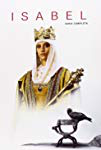

In [711]:
name = "Isabel"
get_cover_img(name)

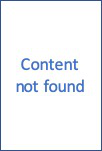

In [394]:
name = "Ultimate Rescue: Pups Save the Movie Monster!" # id =-1
get_cover_img (name)

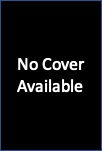

In [395]:
name = "Stolen Princess, The"
get_cover_img (name)

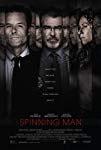

In [396]:
name = "Spinning Man"
get_cover_img (name)

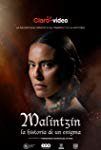

In [397]:
name = "Malintzin, la historia de un enigma"
get_cover_img (name)

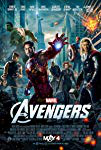

In [398]:
name = "Avengers"
get_cover_img (name)

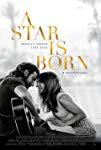

In [713]:
name = "Star Is Born, A (2018)"
get_cover_img (name)

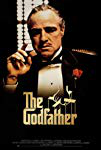

In [229]:
name = "Godfather"
get_cover_img (name)

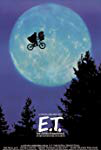

In [820]:
name = "E.T" 
get_cover_img (name, False)

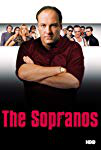

In [757]:
name = "Family Guy" # ==== Problem with API retrieving cover =====
get_cover_img (name)

---

## Creating a Cover Display

In [744]:
def create_cover_display(recs):
    plt.figure(figsize=(15,7))
    columns = 3
    images = []
    names = []
    print ("\n[INFO] Wait, recovering possible covers.....", end = " ")

    name = list(recs.title_1)[0]
    im = get_cover_img (name)
    images.append(im)
    names.append(name)
    
    name = list(recs.title_2)[0]
    im = get_cover_img (name)
    images.append(im)
    names.append(name)
    
    name = list(recs.title_3)[0]
    im = get_cover_img (name)
    images.append(im)
    names.append(name)

    print ("[DONE]")
                
    for i, name in enumerate(names):
        print("Recommendation {}: {}".format(i+1, name))
                
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.grid(b=None)

### Retrieving Movies covers from movie dataset

In [735]:
# Top 10 movie users:
df_movies.ID_CLIENTE.value_counts().index[:10].tolist()

[85528236,
 189425022,
 55974870,
 179898294,
 184452978,
 164059254,
 188409510,
 204602262,
 167361462,
 197353962]

In [699]:
movies = pd.read_csv('recomm_movies_may_19.csv', sep=';')
movies.shape

(40528, 10)


[INFO] Wait, recovering possible covers..... [DONE]
Recommendation 1: Jugando por Amor
Recommendation 2: Novio Por Una Noche
Recommendation 3: I, Tonya


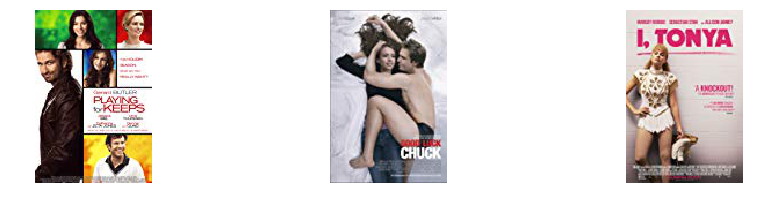

In [745]:
id_client = 85528236
covers = movies[movies.id_client == id_client]
create_cover_display(covers)


[INFO] Wait, recovering possible covers..... [DONE]
Recommendation 1: Resident, The (2011)
Recommendation 2: Zapatero a tus zapatos
Recommendation 3: Querido John


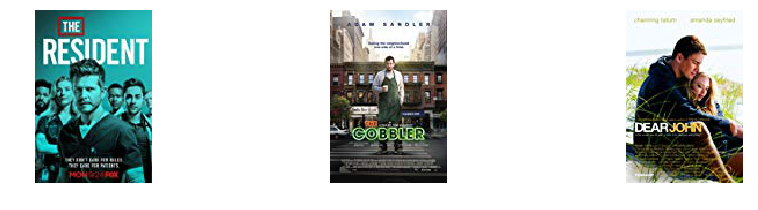

In [746]:
id_client = 164059254
covers = movies[movies.id_client == id_client]
create_cover_display(covers)


[INFO] Wait, recovering possible covers..... [DONE]
Recommendation 1: Evan Almighty
Recommendation 2: Quartet
Recommendation 3: Pretty Woman


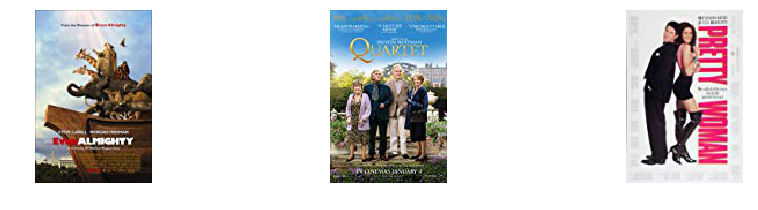

In [747]:
id_client = 189425022
covers = movies[movies.id_client == id_client]
create_cover_display(covers)


[INFO] Wait, recovering possible covers..... [DONE]
Recommendation 1: Piel que habito, La
Recommendation 2: Insidious: Chapter 3
Recommendation 3: Victorio


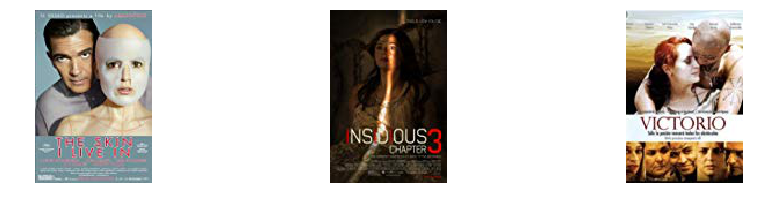

In [748]:
id_client = 199732932
covers = movies[movies.id_client == id_client]
create_cover_display(covers)


[INFO] Wait, recovering possible covers..... [DONE]
Recommendation 1: League of Extraordinary Gentlemen. The
Recommendation 2: Mean Girls (2004)
Recommendation 3: Admiral, The (aka Isoroku Yamamoto)


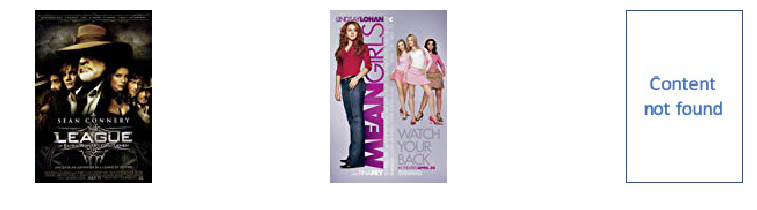

In [754]:
id_client = 151650306 # Low user
covers = movies[movies.id_client == id_client]
create_cover_display(covers)

### Retrieving series covers from movie dataset

In [752]:
# Top 10 serie users:
df_series.ID_CLIENTE.value_counts().index[:10].tolist()

[85528236,
 188409510,
 199610082,
 164059254,
 176583606,
 164178858,
 166000848,
 189553008,
 200284302,
 202831326]

In [691]:
series = pd.read_csv('recomm_series_may_19.csv', sep=';')
series.shape

(40528, 10)

In [784]:
id_client = 164059254
lst = get_user_watched_content(df, id_client, content = 'Serie')
lst.TITULO[:5]

1603                                Planet Earth
10839                                     Castle
25510       Caballeros Las Prefieren Brutas, Los
29644                              Modern Family
32146    Avengers, The: Earths Mightiest Heroes!
Name: TITULO, dtype: object


[INFO] Wait, recovering possible covers..... [DONE]
Recommendation 1: Bienvenida realidad
Recommendation 2: Rubirosa
Recommendation 3: En la boca del lobo


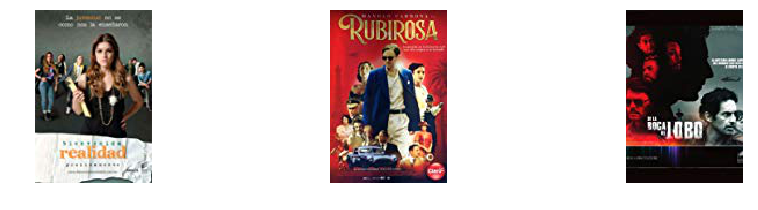

In [819]:
id_client = 164059254
covers = series[series.id_client == id_client]
create_cover_display(covers)


[INFO] Wait, recovering possible covers..... [DONE]
Recommendation 1: Simuladores, Los (México)
Recommendation 2: Bones
Recommendation 3: Avatar: The Legend of Aang: The Beach


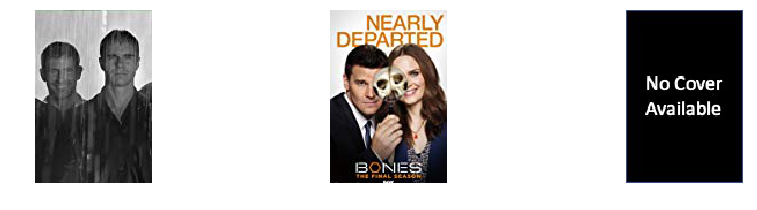

In [753]:
id_client = 85528236
covers = series[series.id_client == id_client]
create_cover_display(covers)


[INFO] Wait, recovering possible covers..... [DONE]
Recommendation 1: 24
Recommendation 2: Isabel
Recommendation 3: Tudors, The


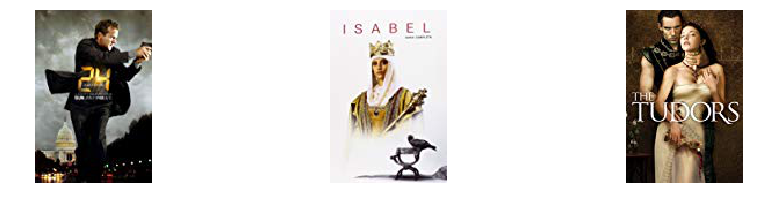

In [751]:
id_client = 184928670
covers = series[series.id_client == id_client]
create_cover_display(covers)


[INFO] Wait, recovering possible covers..... [DONE]
Recommendation 1: Ultimate Spider-Man
Recommendation 2: Saving Grace
Recommendation 3: Family Guy


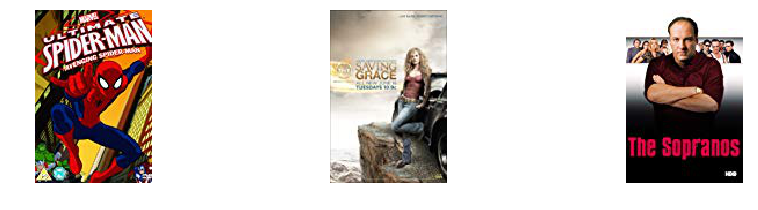

In [756]:
id_client = 151650306 # Low user
covers = series[series.id_client == id_client]
create_cover_display(covers)